## Idea Exploration for PET images generation

1) Try to overfit a single batch
2) Compute mask of the brain and use this to mask out the background and evaluate the loss only on relevant regions
3) Inject clinical information somewhere in the network

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import nibabel as nib
import os
import glob
from os.path import join as opj
from mpl_toolkits.axes_grid1 import ImageGrid
from unet3D import *
from torchsummary import summary
import monai
from monai.transforms import *
from mpl_toolkits.axes_grid1 import ImageGrid
import ssim
import tqdm

## load base data

In [2]:
base_path="/space/matteo/MRIPET"

suv_path=[opj(base_path,"PBRKOA_HC017_041119_suv_orientOK_skullstripped.nii.gz")]
t1_path=[opj(base_path,"T1-2mm_skullstripped_reg2SUV_orientOK.nii.gz")]

### transforms

In [3]:
transform_mri=Compose([CenterSpatialCrop(roi_size=(96,96,96)),ScaleIntensityRangePercentiles(1,99,0,1)])
transform_pet=Compose([CenterSpatialCrop(roi_size=(96,96,96)),ScaleIntensity(0,1)])


In [4]:
idx=0

pet=transform_pet(torch.Tensor(nib.load(suv_path[idx]).get_fdata()).unsqueeze(0))
t1=transform_mri(torch.Tensor(nib.load(t1_path[idx]).get_fdata()).unsqueeze(0))
t1.shape

torch.Size([1, 96, 96, 96])

In [5]:
indices=np.arange(0,90,4)
images_t1=[t1[0,:,:,i] for i in indices][:25]
images_pet=[pet[0,:,:,i] for i in indices][:25]

In [6]:
len(indices)

23

## Model -> 3D Unet

In [7]:
model=UNet3D(image_channels=1,n_channels=32,ch_mults=(1,1,1,1),is_attn=
                (False,False,False,True),n_blocks=1,depthwise_separable=False)

device="cuda:0"
model=model.to(device)
summary(model,(1,96,96,96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 32, 96, 96, 96]             896
         GroupNorm-2       [-1, 32, 96, 96, 96]              64
             Swish-3       [-1, 32, 96, 96, 96]               0
            Conv3d-4       [-1, 32, 96, 96, 96]          27,680
         GroupNorm-5       [-1, 32, 96, 96, 96]              64
             Swish-6       [-1, 32, 96, 96, 96]               0
            Conv3d-7       [-1, 32, 96, 96, 96]          27,680
          Identity-8       [-1, 32, 96, 96, 96]               0
     ResidualBlock-9       [-1, 32, 96, 96, 96]               0
         Identity-10       [-1, 32, 96, 96, 96]               0
        DownBlock-11       [-1, 32, 96, 96, 96]               0
           Conv3d-12       [-1, 32, 48, 48, 48]          27,680
       Downsample-13       [-1, 32, 48, 48, 48]               0
        GroupNorm-14       [-1, 32, 48,

[INFO] mean, std, min, max: (tensor(0.0981), tensor(0.2532), tensor(0.), tensor(1.2766))


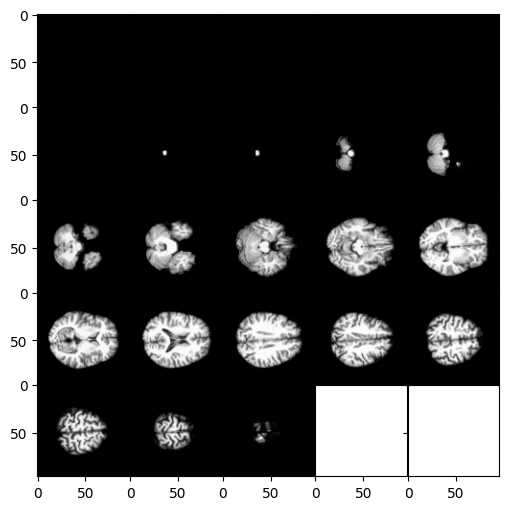

In [8]:
fig = plt.figure(figsize=(6,6))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(5, 5),  # creates 2x2 grid of axes
                 axes_pad=0.01,  # pad between axes in inch.
                 )

print(f"[INFO] mean, std, min, max: {t1.mean(), t1.std(), t1.min(), t1.max()}")

for ax, im in zip(grid, images_t1):
    # Iterating over the grid returns the Axes.
    ax.imshow(im.squeeze(),cmap="gray")

plt.show()



[INFO] mean, std, min, max: (tensor(0.0182), tensor(0.0473), tensor(0.), tensor(1.))


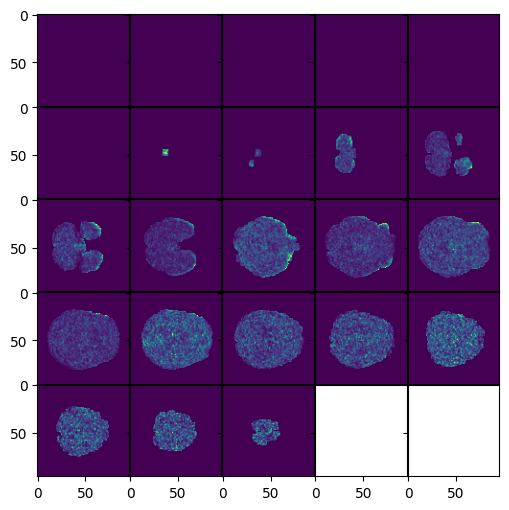

In [9]:
fig = plt.figure(figsize=(6,6))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(5, 5),  # creates 2x2 grid of axes
                 axes_pad=0.01,  # pad between axes in inch.
                 )

print(f"[INFO] mean, std, min, max: {pet.mean(), pet.std(), pet.min(), pet.max()}")

for ax, im in zip(grid, images_pet):
    # Iterating over the grid returns the Axes.
    ax.imshow(im.squeeze())

plt.show()


## Datasets and Dataloaders

In [10]:
class MRIPETDataset(torch.utils.data.Dataset):
    """Face Landmarks dataset."""

    def __init__(self, mri_paths, pet_paths, transform_mri=None,transform_pet=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.mri_paths = mri_paths
        self.pet_paths = pet_paths
        self.transform_mri = transform_mri
        self.transform_pet = transform_pet

    def __len__(self):
        return len(self.mri_paths)

    def __getitem__(self, idx):
       
    
        
        pet=torch.Tensor(nib.load(self.pet_paths[idx]).get_fdata()).unsqueeze(0)
        mri=torch.Tensor(nib.load(self.mri_paths[idx]).get_fdata()).unsqueeze(0)
        
        

        if self.transform_pet:
            pet = self.transform_pet(pet)
    
        if self.transform_mri:
            mri = self.transform_mri(mri)
            
        mask=(mri>0)*1.

        return mri,pet,mask

In [11]:
dataset=MRIPETDataset(mri_paths=t1_path,pet_paths=suv_path,transform_mri=transform_mri,transform_pet=transform_pet)
dataloader=torch.utils.data.DataLoader(dataset,batch_size=1)

In [12]:
x,y,mask=next(iter(dataloader))

In [13]:
x.shape,y.shape

(torch.Size([1, 1, 96, 96, 96]), torch.Size([1, 1, 96, 96, 96]))

[INFO] mean, std, min, max: (tensor(0.0182), tensor(0.0473), tensor(0.), tensor(1.))


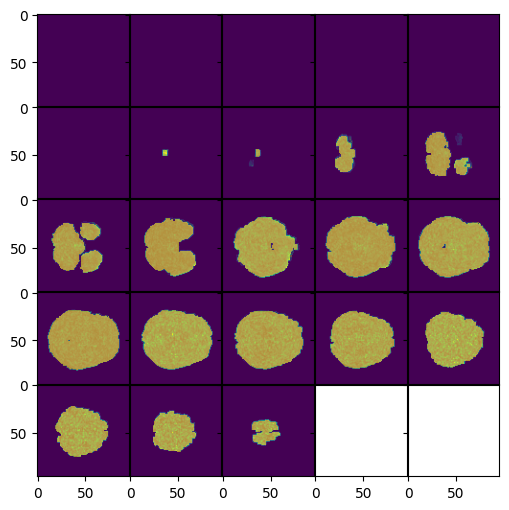

In [14]:
pet_images=[y[0,0,:,:,i].detach().cpu() for i in indices][:25]
mask_images=[mask[0,0,:,:,i].detach().cpu() for i in indices][:25]

fig = plt.figure(figsize=(6,6))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(5, 5),  # creates 2x2 grid of axes
                 axes_pad=0.01,  # pad between axes in inch.
                 )

print(f"[INFO] mean, std, min, max: {pet.mean(), pet.std(), pet.min(), pet.max()}")

for ax, im, mask_im in zip(grid, pet_images,mask_images):
    # Iterating over the grid returns the Axes.
    ax.imshow(im.squeeze())
    ax.imshow(mask_im.squeeze(),alpha=0.6)

plt.show()


## Overfit a single batch

In [15]:
optim=torch.optim.Adam(model.parameters(),lr=1e-4)

In [16]:
mse_loss=nn.MSELoss()
ssim_loss = ssim.SSIM3D(window_size = 11)
bce_loss=nn.BCELoss()

In [20]:
def criterion(y_pred,y,mse_weight=1.,bce_weight=1.,ssim_weight=0):
    return mse_weight*mse_loss(y_pred,y)+bce_weight*bce_loss(y_pred,y)+ssim_weight*ssim_loss(y_pred,y)


In [21]:
n_steps=50

loss_history=[]
pbar=tqdm.tqdm(range(n_steps))
for i in pbar:
    for x,y,m in dataloader:
        
        optim.zero_grad()
        x,y,m=x.to(device),y.to(device),m.to(device)
        y_pred=model(x)
        #use the mask
        y_pred=m*y_pred
        
        #compute masked_loss
        loss=criterion(y_pred,m*y)
        loss.backward()
        optim.step()
        
        pbar.set_description(f"epoch {i} loss: {loss.item()}")
        loss_history.append(loss.item())
    

epoch 49 loss: 0.0546393059194088: 100%|██████████| 50/50 [01:37<00:00,  1.94s/it]  


In [22]:
predicted_images_pet=[y_pred[0,0,:,:,i].detach().cpu() for i in indices][:25]

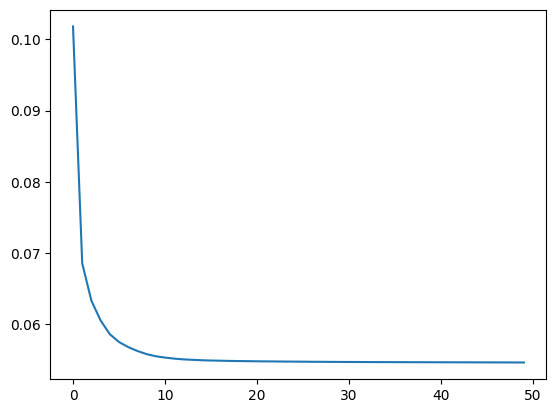

In [23]:
plt.plot(loss_history)
plt.show()

In [24]:
y_pred=y_pred.detach().cpu()

[INFO] mean, std, min, max: (tensor(0.0168), tensor(0.0383), tensor(0.), tensor(0.2268))


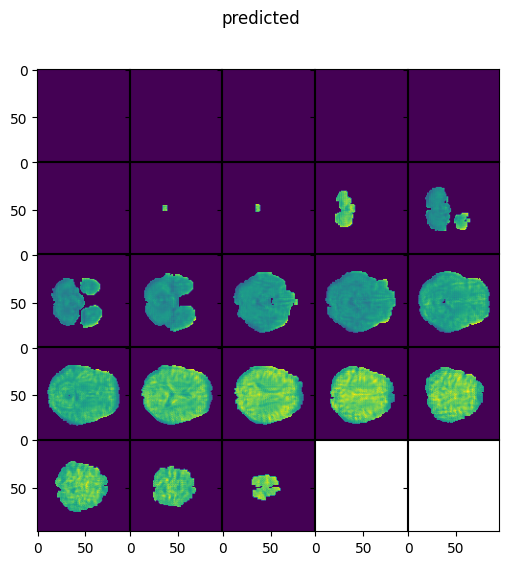

In [25]:
fig = plt.figure(figsize=(6,6))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(5, 5),  # creates 2x2 grid of axes
                 axes_pad=0.01,  # pad between axes in inch.
                 )

print(f"[INFO] mean, std, min, max: {y_pred.mean(), y_pred.std(), y_pred.min(), y_pred.max()}")

for ax, im in zip(grid, predicted_images_pet):
    # Iterating over the grid returns the Axes.
    ax.imshow(im.squeeze())
plt.suptitle("predicted")

plt.show()


[INFO] mean, std, min, max: (tensor(0.0182), tensor(0.0473), tensor(0.), tensor(1.))


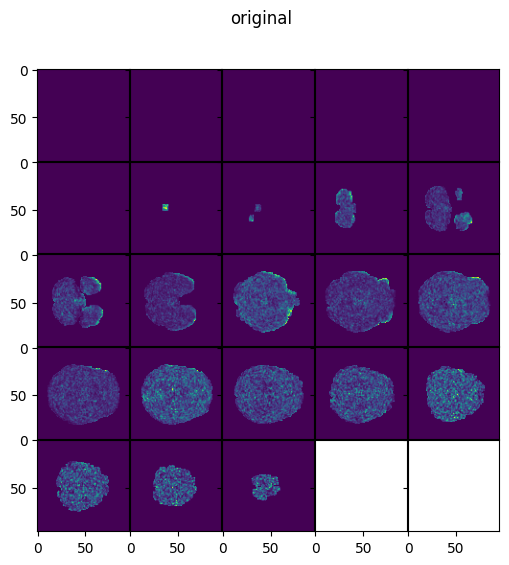

In [26]:
fig = plt.figure(figsize=(6,6))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(5, 5),  # creates 2x2 grid of axes
                 axes_pad=0.01,  # pad between axes in inch.
                 )

print(f"[INFO] mean, std, min, max: {pet.mean(), pet.std(), pet.min(), pet.max()}")

for ax, im in zip(grid, images_pet):
    # Iterating over the grid returns the Axes.
    ax.imshow(im.squeeze())
plt.suptitle("original")
plt.show()
